In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from functools import reduce

spm = pd.read_csv('SPM/spm_results.csv', sep=',')
scc = pd.read_csv('SCC/scc_results.csv', sep=',')

assert (all(spm.columns == scc.columns))

data = pd.concat([spm, scc]);
data

,config,memorder,voting-strat,tpb,ipt,algorithm,problem_type,problem_size,runtime
0,relaxed-naive-alternating-256-32,relaxed,naive-alternating,256,32,SPM,invariantly_inevitably_eat,2,0.96800005
1,relaxed-naive-alternating-256-32,relaxed,naive-alternating,256,32,SPM,invariantly_inevitably_eat,4,14.787
2,relaxed-naive-alternating-256-32,relaxed,naive-alternating,256,32,SPM,invariantly_inevitably_eat,6,1000.004
3,relaxed-naive-alternating-256-32,relaxed,naive-alternating,256,32,SPM,invariantly_inevitably_eat,8,12585.703
4,relaxed-naive-alternating-256-32,relaxed,naive-alternating,256,32,SPM,invariantly_inevitably_eat,10,non-zero exitcode.
...,...,...,...,...,...,...,...,...,...
763,relaxed-naive-alternating-512-16,relaxed,naive-alternating,512,16,SCC_MP,random_0.01,999898,non-zero exitcode (gridsize).
764,relaxed-naive-alternating-512-16,relaxed,naive-alternating,512,16,SCC_MP,random_0.1,100095,0.30215997
765,relaxed-naive-alternating-512-16,relaxed,naive-alternating,512,16,SCC_MP,random_0.1,624033,0.71009916
766,relaxed-naive-alternating-512-16,relaxed,naive-alternating,512,16,SCC_MP,random_0.1,2500146,non-zero exitcode (gridsize).


In [2]:

data = data.drop(data[data["runtime"].apply(lambda x : x.startswith("non-zero exitcode"))].index)
data = data.drop(data[data["runtime"] == "NaN"].index)
data["runtime"] = data["runtime"].astype(float);
data["problem_size"] = data["problem_size"].astype(int);
data["ipt"] = data["ipt"].astype(int);
data["tpb"] = data["tpb"].astype(int);

data

,config,memorder,voting-strat,tpb,ipt,algorithm,problem_type,problem_size,runtime
0,relaxed-naive-alternating-256-32,relaxed,naive-alternating,256,32,SPM,invariantly_inevitably_eat,2,0.968000
1,relaxed-naive-alternating-256-32,relaxed,naive-alternating,256,32,SPM,invariantly_inevitably_eat,4,14.787000
2,relaxed-naive-alternating-256-32,relaxed,naive-alternating,256,32,SPM,invariantly_inevitably_eat,6,1000.004000
3,relaxed-naive-alternating-256-32,relaxed,naive-alternating,256,32,SPM,invariantly_inevitably_eat,8,12585.703000
5,relaxed-naive-512-4,relaxed,naive,512,4,SPM,invariantly_inevitably_eat,2,1.196000
...,...,...,...,...,...,...,...,...,...
760,relaxed-naive-alternating-512-16,relaxed,naive-alternating,512,16,SCC_MP,random_0.01,9813,0.464726
761,relaxed-naive-alternating-512-16,relaxed,naive-alternating,512,16,SCC_MP,random_0.01,62582,0.409232
762,relaxed-naive-alternating-512-16,relaxed,naive-alternating,512,16,SCC_MP,random_0.01,250467,0.522835
764,relaxed-naive-alternating-512-16,relaxed,naive-alternating,512,16,SCC_MP,random_0.1,100095,0.302160


In [3]:
""" Returns all rows with a configuration that is present
    for all possible values of variable_parameter, such that
    the only configuration-related difference between rows 
    is the variable_parameter.
"""
def get_comparable_rows(rows, variable_parameter):
    # Group rows by config, except for the variable_parameter
    config_cols = ["memorder", "voting-strat", "tpb", "ipt", "problem_size", "algorithm", "problem_type"];
    config_cols.remove(variable_parameter);
    
    # Compute all available variable_parameter options
    p_options = rows[variable_parameter].unique();
    
    # Per possible value of variable_parameter, get the corresponding rows
    rows_per_option = [rows[rows[variable_parameter] == opt] for opt in p_options];
    
    # Find the unique configs present per value of variable_parameter
    sets_of_configs = [set(r.groupby(config_cols).groups.keys()) for r in rows_per_option];
    
    # Get configs which are present for all possible values of variable_parameter
    shared_configs = list(reduce((lambda x, y : x & y), sets_of_configs));
    
    # Return all rows which have a shared config
    by_config = rows.groupby(config_cols);
    comp_rows = [];
    for (c, c_rows) in by_config:
        if c in shared_configs:
            comp_rows.append(c_rows);
    if comp_rows == []:
        print("WARNING: EMPTY ROWS TO COMPARE");
        return pd.DataFrame(data={});
    comparable_rows = pd.concat(comp_rows);
        
    return comparable_rows;


In [4]:
def bar_chart(rows, title, variable_parameter, ordering=None, yscale="log", xlabel="Problem size", xscale="linear"):
    if ordering == None:
        ordering = rows[variable_parameter].unique();
    assert (len(ordering) == len(rows[variable_parameter].unique()))
    
    plt.figure();
    plt.title(title);
    rows = get_comparable_rows(rows, variable_parameter);
    tot_width = 0.8;
    width = tot_width / len(ordering);
    offset = - 0.5 * tot_width + 0.5 * width;
    
    ys = [];
    p_sizes = list(rows["problem_size"].unique());
    p_sizes.sort();
    nrof_values = len(p_sizes);
    
    for o, rows in [(o, rows[rows[variable_parameter] == o]) for o in ordering]:
        Y = rows.groupby("problem_size")["runtime"].mean();
        assert(nrof_values == len(Y.values));
        X = [x + offset for x in range(len(Y.values))];
        ys.append(Y);
        plt.bar(X, Y.values, width=width, label=o);
        offset += width;
    plt.xlabel(xlabel);
    plt.xscale(xscale);
    plt.xticks(range(nrof_values), [str(round(p, -3)/1000)+"K" for p in p_sizes]);
    plt.yscale(yscale);
    plt.ylabel("runtime (ms)");
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left");
    plt.show();
    return ys;

def scatter_chart(rows, title, variable_parameter, ordering=None, yscale="log", xlabel="Problem size", xscale="linear"):
    if ordering == None:
        ordering = rows[variable_parameter].unique();
    assert (len(ordering) == len(rows[variable_parameter].unique()))
    
    plt.figure();
    plt.title(title);
    rows = get_comparable_rows(rows, variable_parameter);
    cols = ["C0", "C1", "C2", "C3", "C4", "C5"];
    col_idx = 0;
    for o, rows in [(o, rows[rows[variable_parameter] == o]) for o in ordering]:
        for c, rows in rows.groupby("config"):
            plt.plot(rows["problem_size"], rows["runtime"], color=cols[col_idx % len(cols)], label=o);
        col_idx += 1;
    
    plt.xlabel(xlabel);
    plt.xscale(xscale);
    plt.yscale(yscale);
    plt.ylabel("runtime (ms)");
    patches = [mpatches.Patch(color=cols[i % len(cols)], label=ordering[i]) for i in range(len(ordering))];
    plt.legend(handles=patches, bbox_to_anchor=(1.04, 1), loc="upper left");
    plt.show();

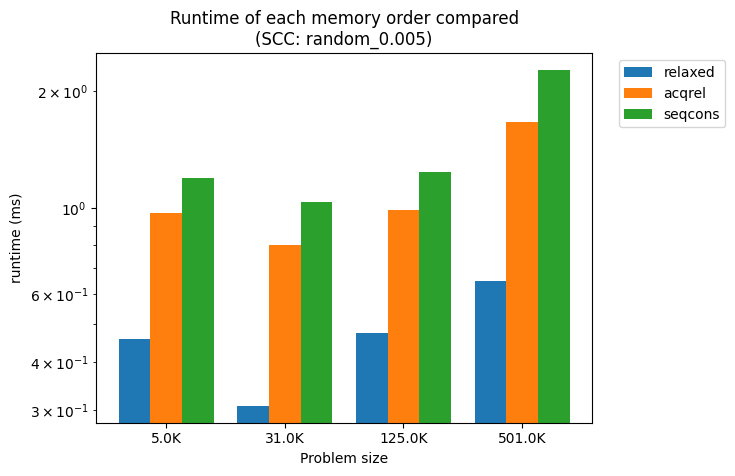

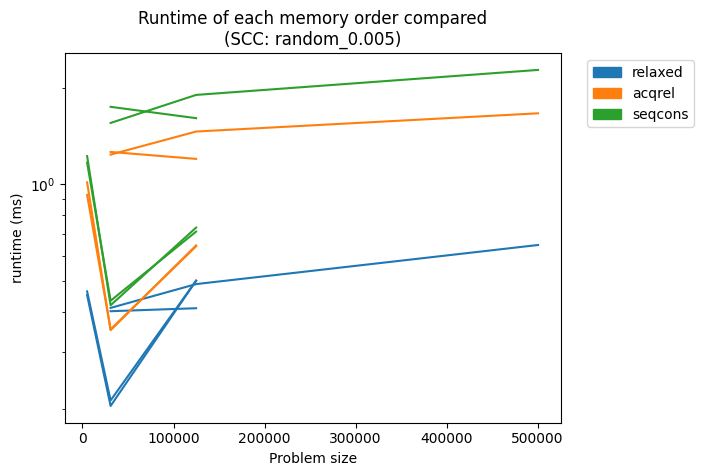

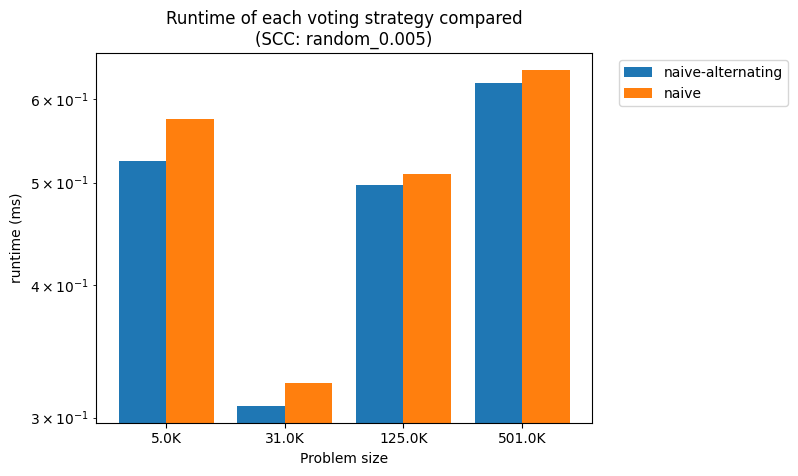

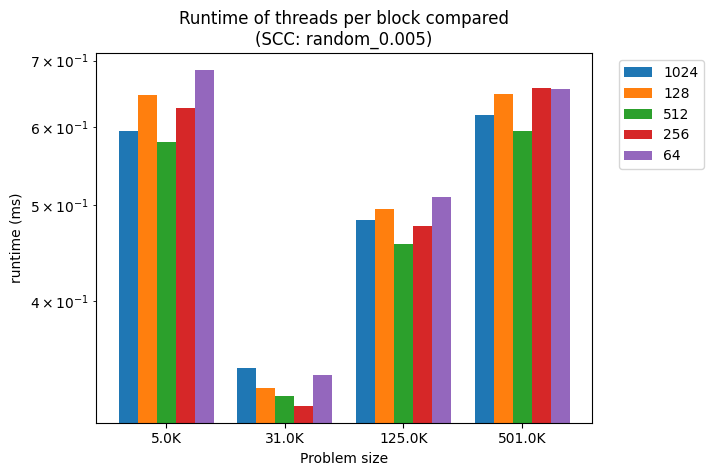

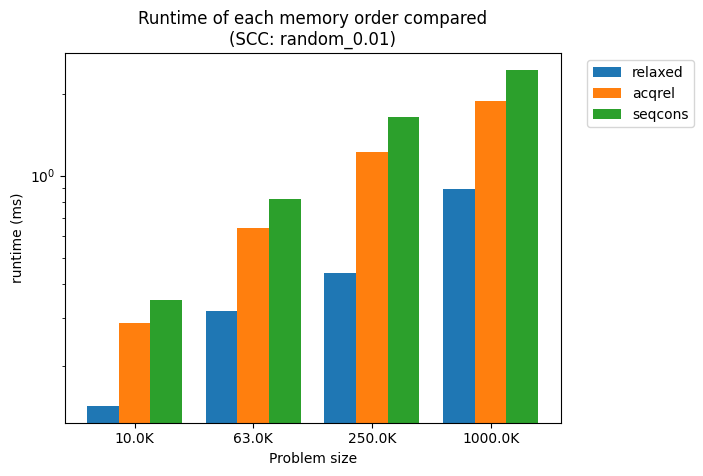

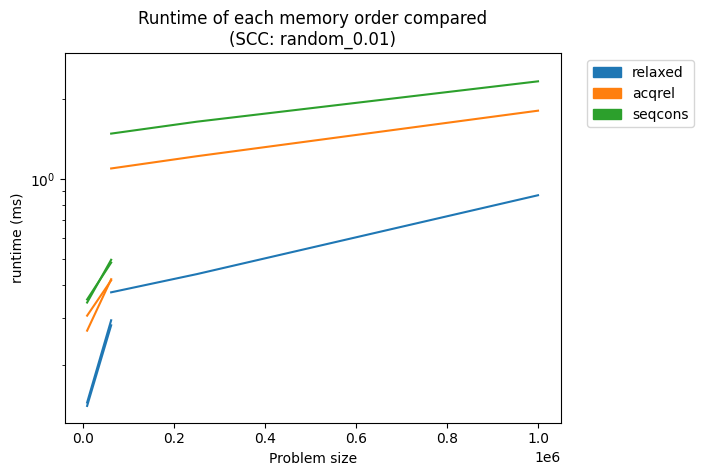

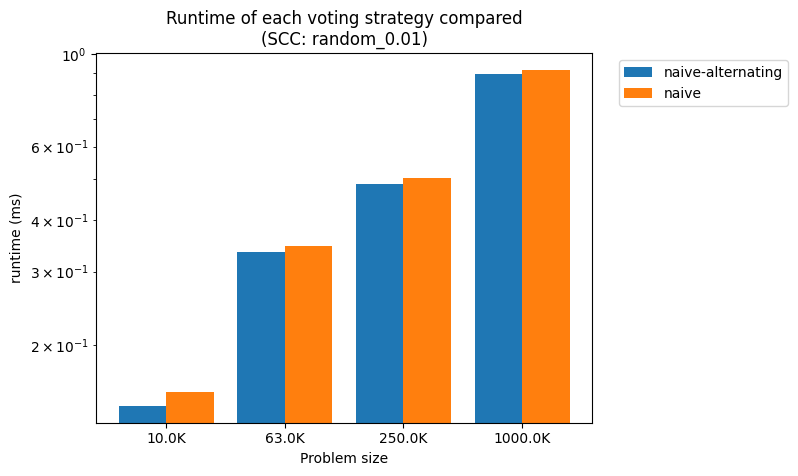

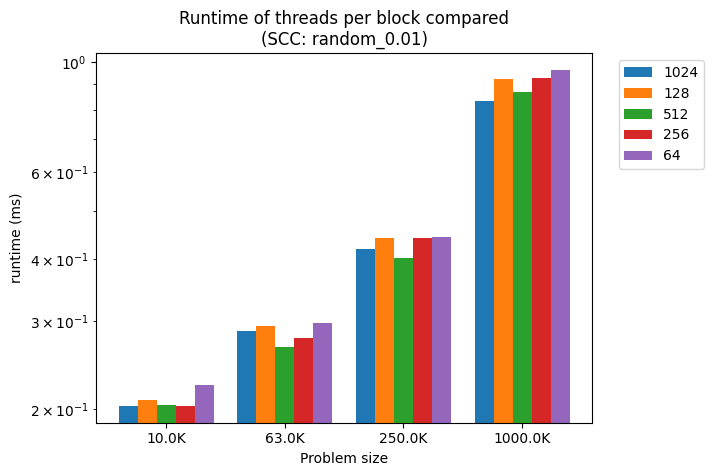

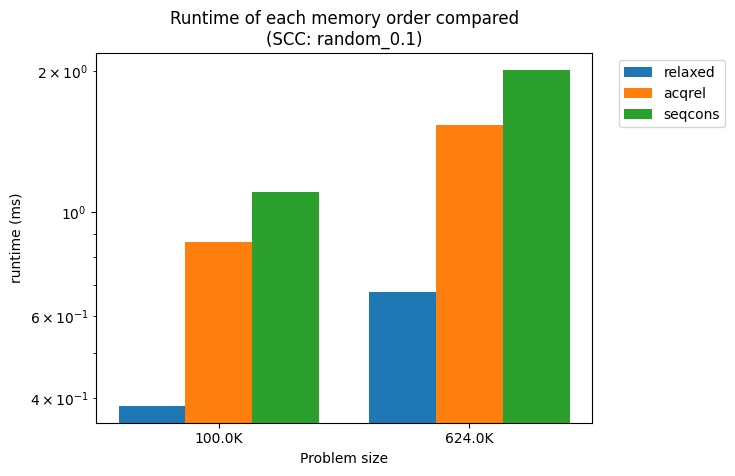

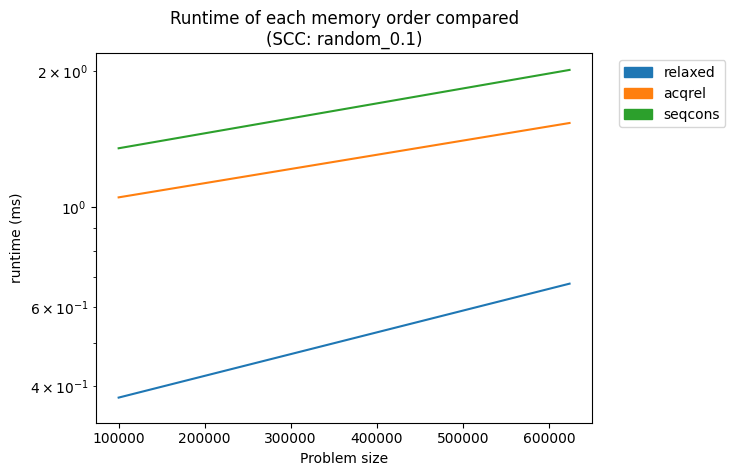

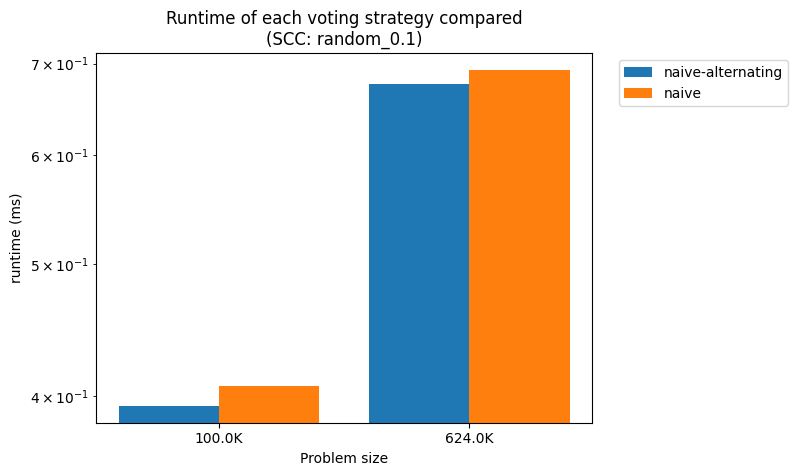

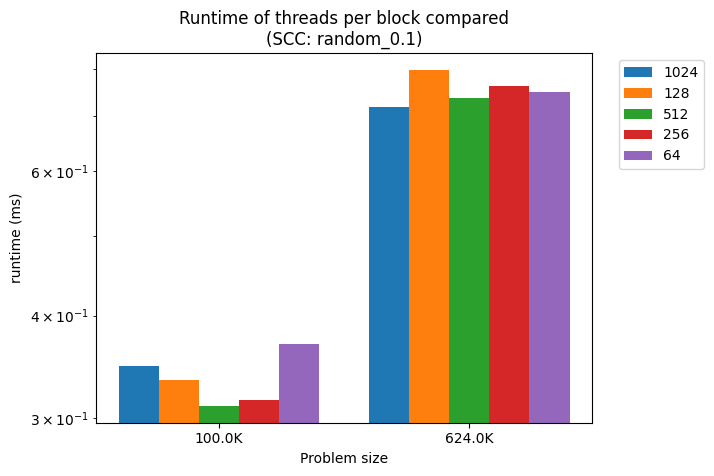

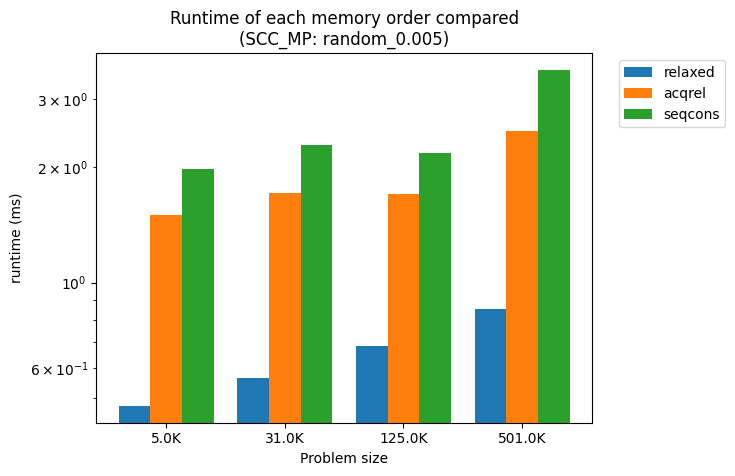

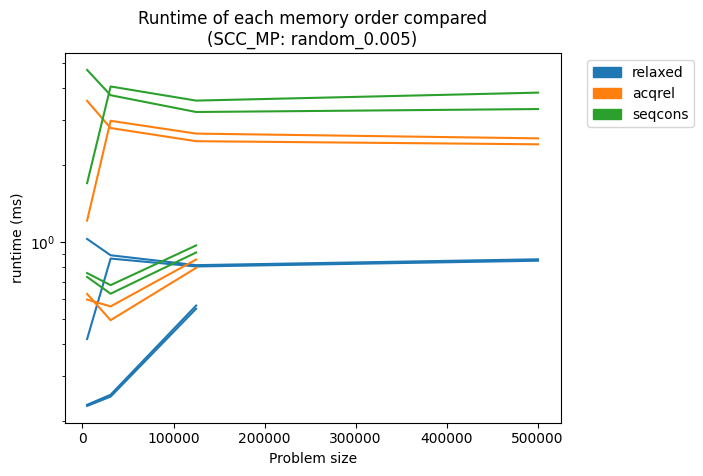

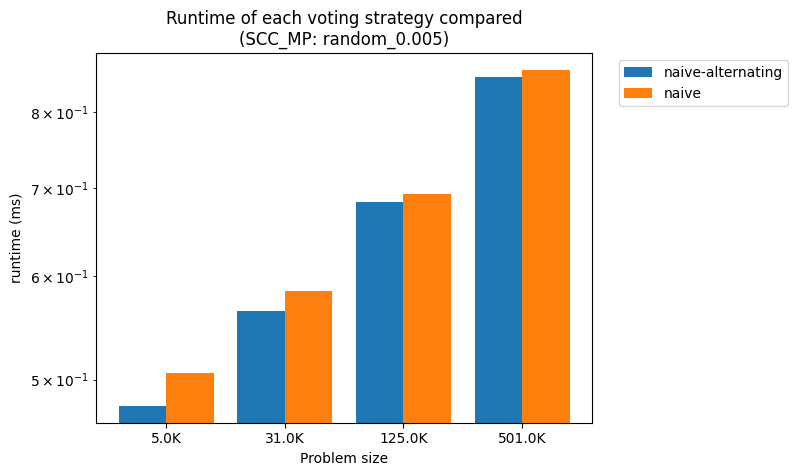

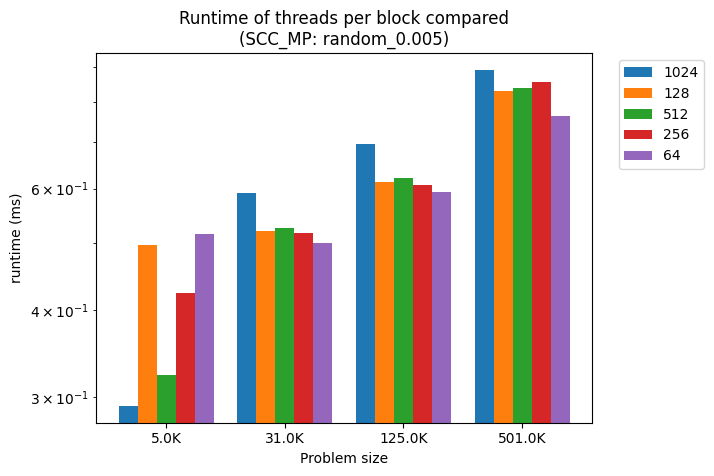

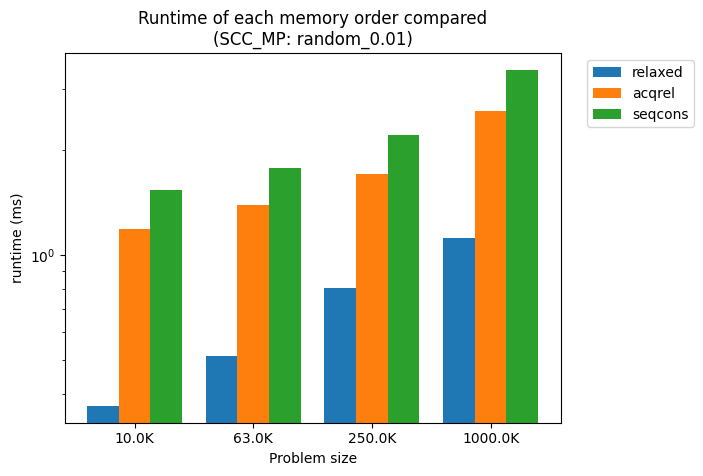

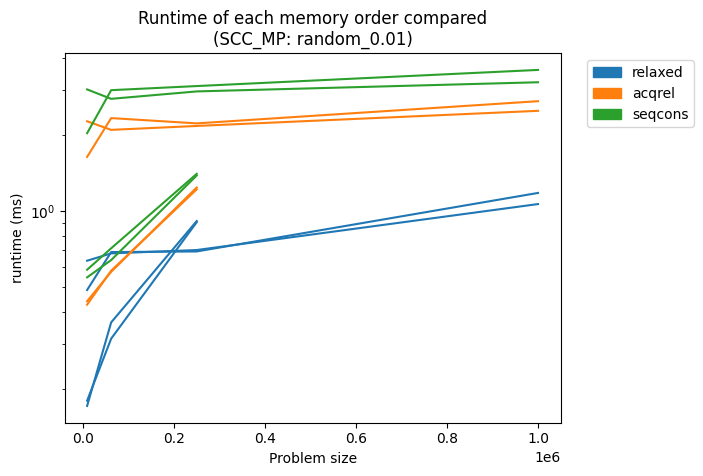

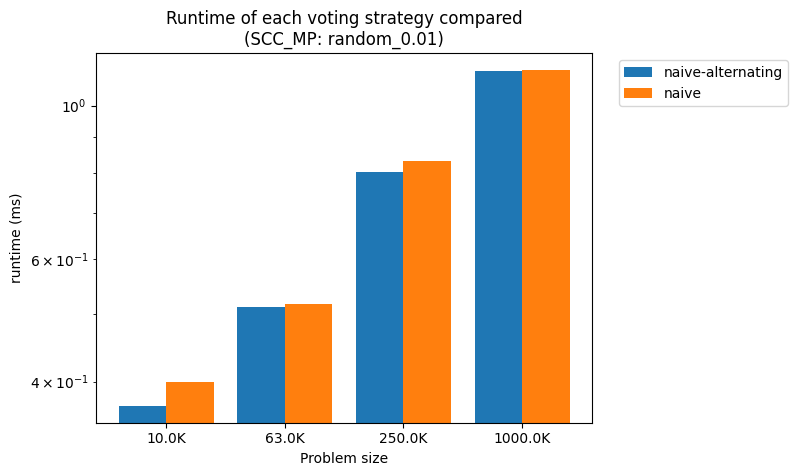

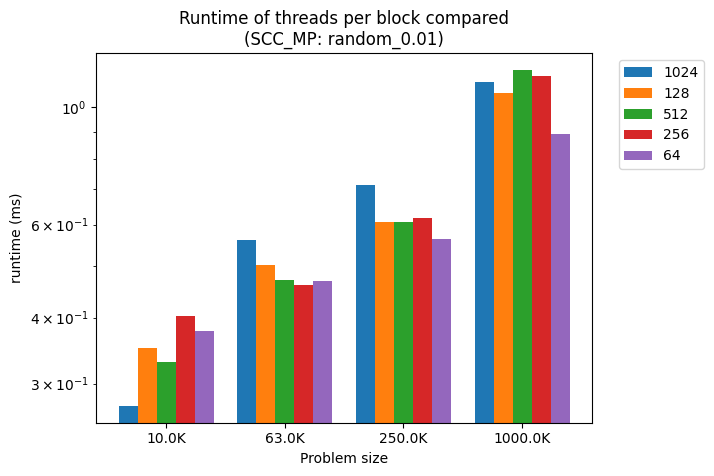

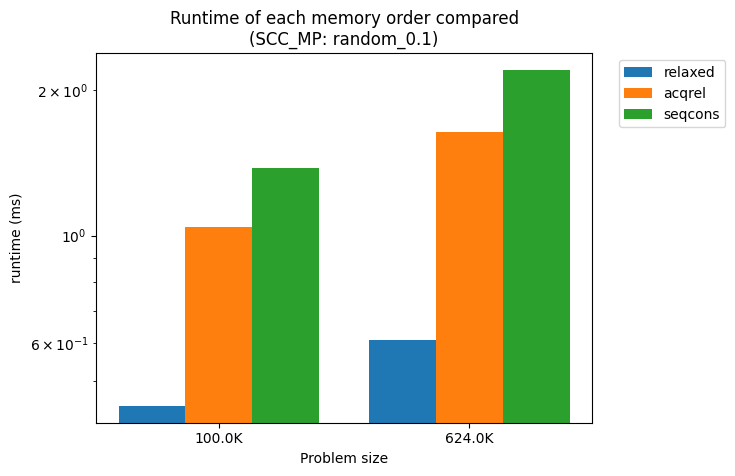

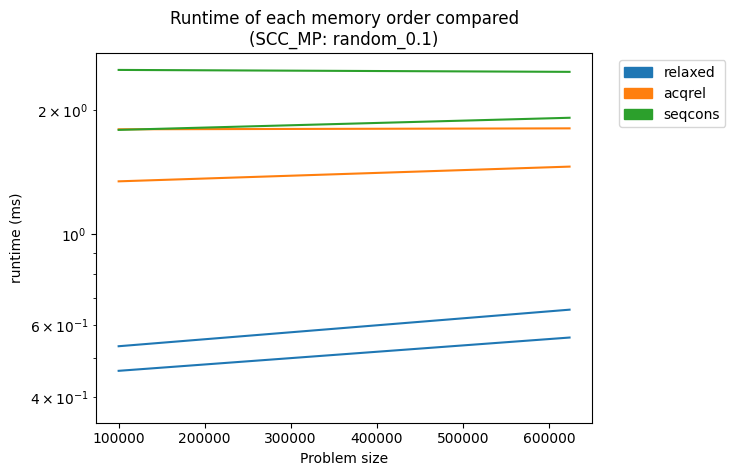

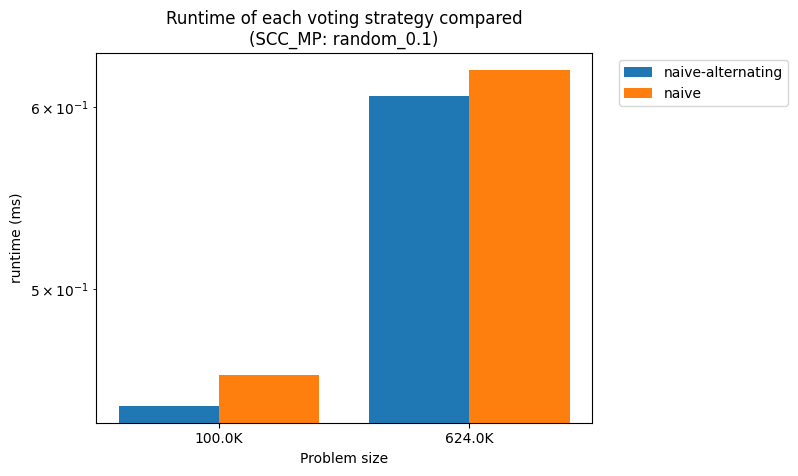

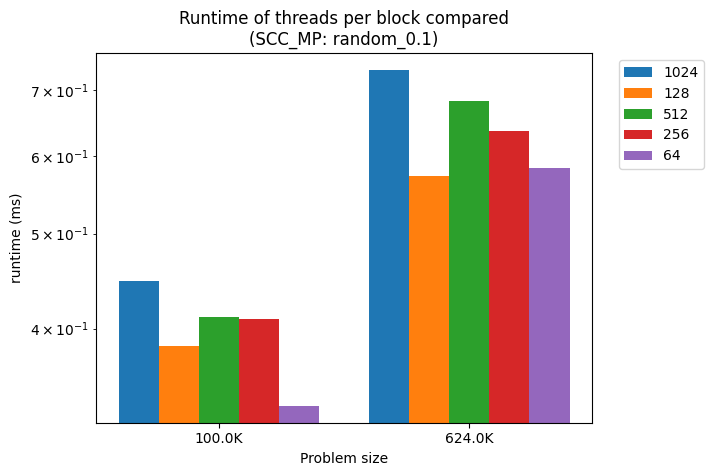

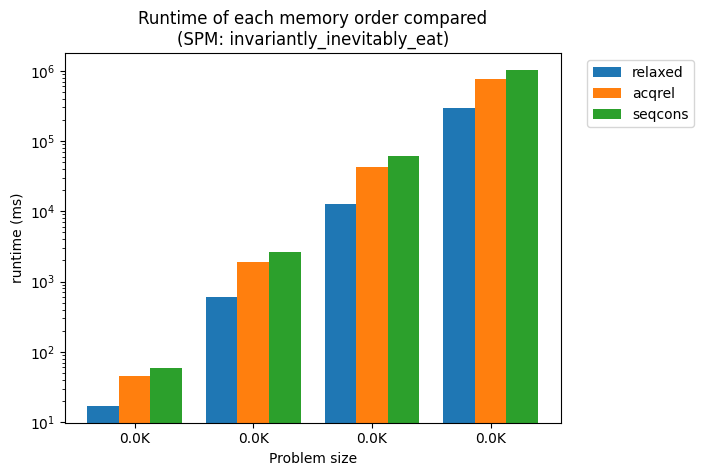

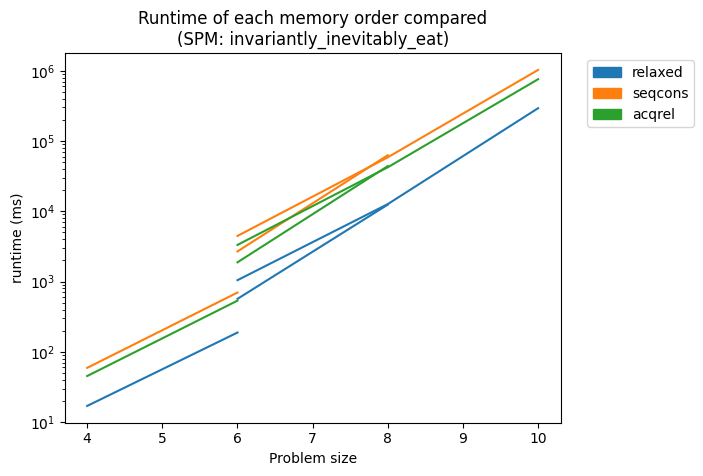

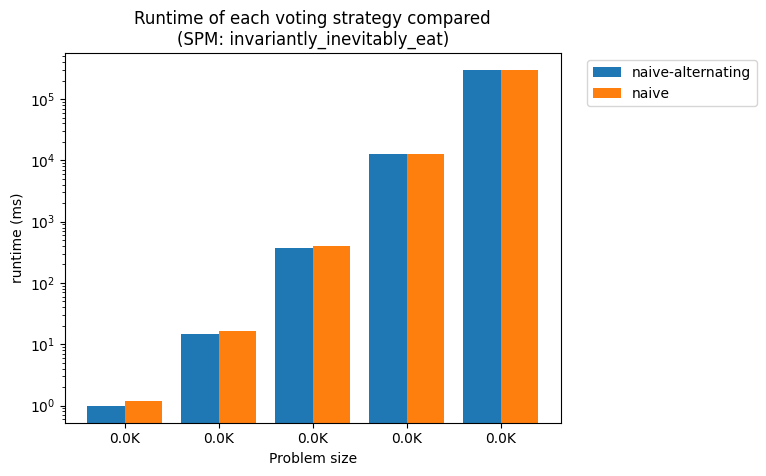

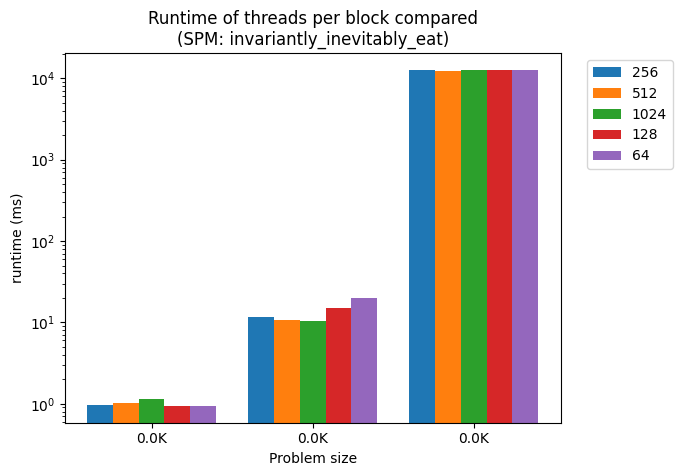

In [5]:
for alg, alg_rows in data.groupby("algorithm"):
    for p_type, p_type_rows in alg_rows.groupby("problem_type"):
        ys = bar_chart(
            p_type_rows,
            f"Runtime of each memory order compared\n({alg}: {p_type})",
            "memorder",
            ["relaxed", "acqrel", "seqcons"],
        );
        
        scatter_chart(
            p_type_rows,
            f"Runtime of each memory order compared\n({alg}: {p_type})",
            "memorder",
        );
        
        ys = bar_chart(
            p_type_rows,
            f"Runtime of each voting strategy compared\n({alg}: {p_type})",
            "voting-strat",
            ["naive-alternating", "naive"],
        );
        
        ys = bar_chart(
            p_type_rows,
            f"Runtime of threads per block compared\n({alg}: {p_type})",
            "tpb",
        );

In [6]:
for f, rows in per_formula:
    ys = bar_chart(
        rows,
        f"Runtime of each voting strategy compared\n(SPM: {f})",
        "voting-strat",
        ["naive-alternating", "naive"]
    );
    print(f"Naive/Naive-alternating:");
    print(ys[1]/ys[0]);

    
    

NameError: name 'per_formula' is not defined

In [ ]:
for f, rows in per_formula:
    ys = bar_chart(
        rows,
        f"Runtime of IPT compared\n(SPM: {f})",
        "ipt",
        [1, 4, 16, 32]
    );


In [ ]:
for f, rows in per_formula:
    ys = bar_chart(
        rows,
        f"Runtime of TPB compared\n(SPM: {f})",
        "tpb",
        [1024, 512, 256, 128, 64]
    );

In [ ]:
tot_width = 2;

for f, rows in per_formula:
    if f != "invariantly_inevitably_eat":
        continue;
        
    configs = rows.sort_values(by=['ipt'])["config"].unique();
    configs = [c for c in configs if c.startswith("relaxed")];
    width =  tot_width / len(configs);
    offset = - 0.5 * tot_width + 0.5 * width;
    
    plt.figure(figsize=(15,8));
    plt.title(f"{f}")
    ys = [];
    for c in configs:
        c_rows = rows[rows["config"] == c];
        X = c_rows["problemsize"];
        Y = c_rows["runtime"];
        if c_rows["ipt"].iloc[0] == 1:
            h = '/';
        elif c_rows["ipt"].iloc[0] == 16:
            h = 'o';
        elif c_rows["ipt"].iloc[0] == 32:
            h = '*';
        else:
            h = '+';
        
        if c_rows["tpb"].iloc[0] == 128:
            a = 1;
        else:
            a = 0.3;
        
        plt.bar(X + offset, Y, width, label=c, hatch=h, alpha=a);
        offset += width;
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left");
    plt.xlabel("Problem size");
    plt.ylabel("Log runtime (ms)");
    plt.yscale("log");
    plt.show();
